In [3]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath("../../"))
from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [7]:
from src.pdf_utils.chains import (
    Page2ImageChain,
    Pdf2ImageChain,
    ImageEncodeChain,
    ImageLoaderChain,
    VisionAnalysisChain
)
from src.pdf_utils.pdf2image import page2image
from src.config import Navigator

from textwrap import dedent
from pprint import pprint

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnablePick
from IPython.display import Image, display
import os
from operator import itemgetter

import fitz  # PyMuPDF

In [8]:
nav = Navigator()

def get_pdf_page(fname_substr, page):
    files = nav.find_file_by_substr(
        fname_substr, 
        base_dir=nav.raw / "weird-slides"
    )
    file = files[0]
    pdf = fitz.open(file)
    return pdf[page]

pages = []

# Слайд с графиком
pages.append(get_pdf_page("ЯиП_Энергетический_переход_Вызовы_и_возможности", 0))

# Слайд с таблицей
pages.append(get_pdf_page("SP_Навигатор_по_мерам_гос_поддержки", 1))

# Слайд где много текста
pages.append(get_pdf_page("Accenture", 0))

# Слайд с картинкой
pages.append(get_pdf_page("ЯиП_Энергетический_переход_Вызовы_и_возможности", 4))

Посмотрим на слайды

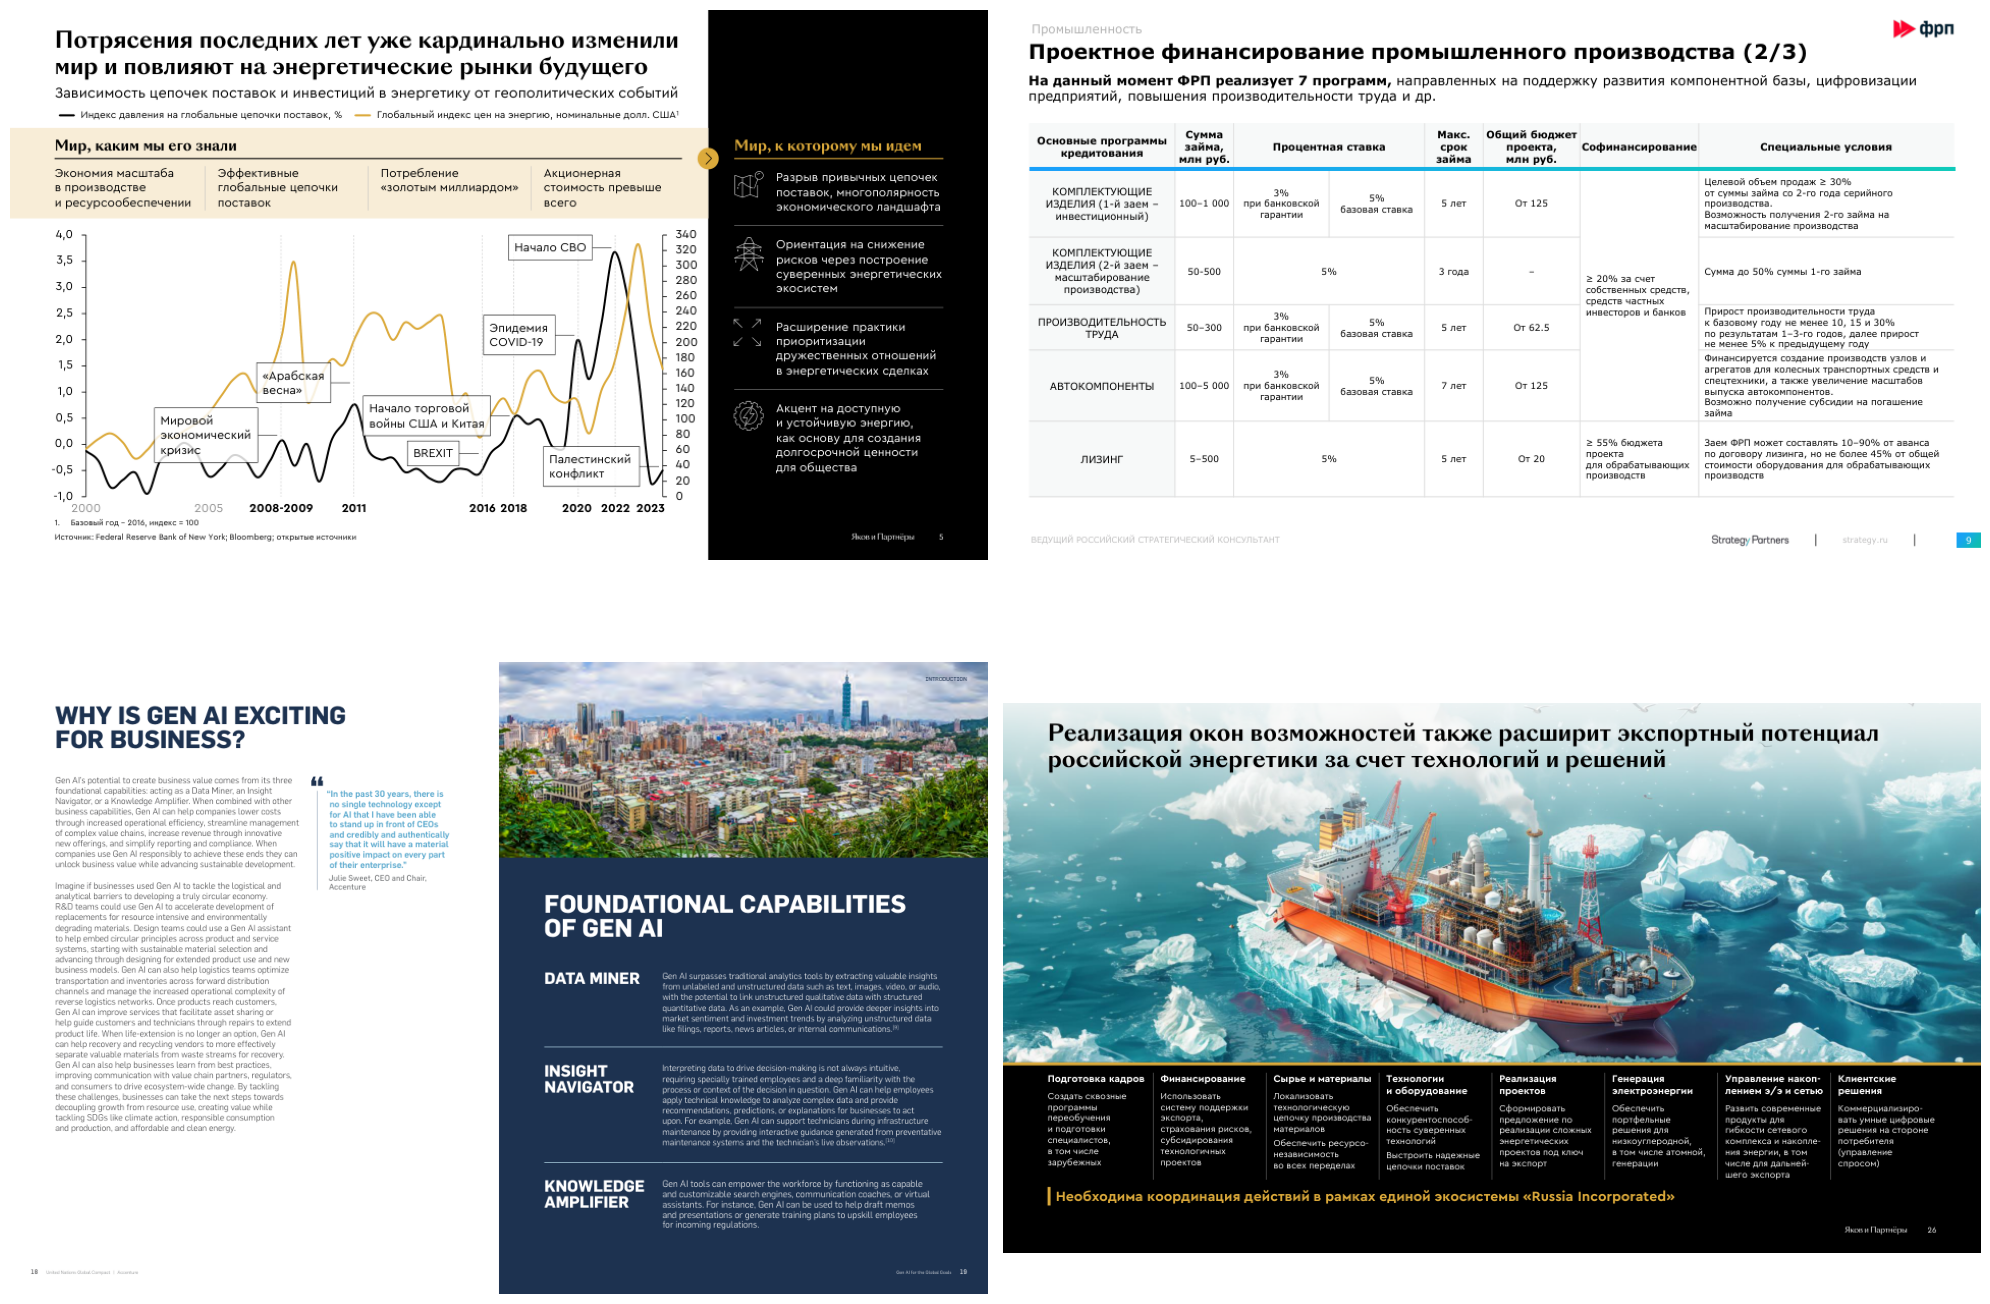

In [82]:
import matplotlib.pyplot as plt

images_demo = [page2image(page) for page in pages]
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

for image, ax in zip(images_demo, axs.flat):
    ax.imshow(image)
    ax.axis("off")

fig.tight_layout()

In [17]:
from operator import itemgetter
dpi_list = [
    72, # 1080p - original, no scale
    48, # 720p
    36, # 540
    24, # 360
    16  # 240
] 

api_base = os.environ["VSEGPT_API_BASE"]
api_key = os.environ["VSEGPT_API_KEY"]
model = "vis-openai/gpt-4o"
temperature = 0.0

llm = ChatOpenAI(
    base_url=api_base,
    model=model,
    api_key=api_key,
    temperature=temperature
)

vision_prompt = dedent(
"""\
Представь, что я ничего не вижу. \
Я пришлю тебе слайд из презентации, а ты опиши его. \
Передай мне содержимое слайда в мельчайших подробностях.
""")

from langchain.globals import set_debug, set_verbose
set_debug(False)

chain = (
    ImageEncodeChain()
    | VisionAnalysisChain(llm=llm, prompt=vision_prompt)
)

In [10]:
from textwrap import TextWrapper
from typing import Optional
from functools import  partial
from PIL import Image
import matplotlib.pyplot as plt

from src.config import MultilineWrapper

text_wrapper = MultilineWrapper(width=90)

def query_and_display(
    pil_image: Image, 
    vision_prompt: Optional[str] = None, 
    wrap_width=90, 
    display_image=True
):
    """
    Shortcut to query model and format output.
    
    Returns output without wrapping 
    """
    if display_image:
        # Create a figure with a fixed size (e.g., 8 inches wide and 6 inches tall)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(pil_image)
        ax.axis('off')
        plt.show()

    text_wrapper.width = wrap_width
    
    out = chain.invoke(dict(
        image=pil_image,
        vision_prompt=vision_prompt
    ))
    llm_output = out["llm_output"]
    print(text_wrapper.fill(llm_output))
    return out

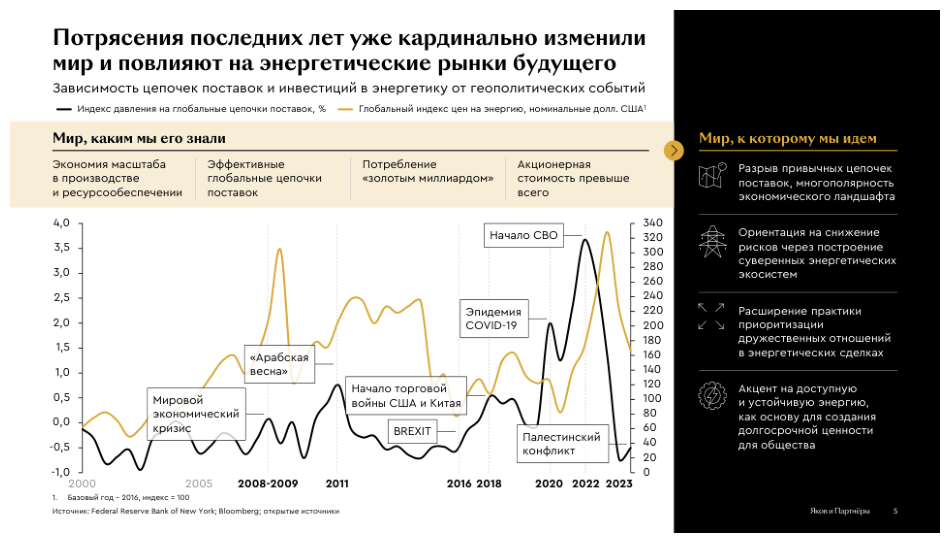

Слайд из презентации содержит информацию о влиянии геополитических событий на 
энергетические рынки.

### Заголовок:
- **Потрясения последних лет уже кардинально изменили мир и повлияют на энергетические 
рынки будущего**

### Подзаголовок:
- **Зависимость цепочек поставок и инвестиций в энергетике от геополитических событий**

### График:
- **Ось Y слева**: Индекс давления на глобальные цепочки поставок (в процентах)
- **Ось Y справа**: Глобальный индекс цен на энергию (в долларах США)
- **Ось X**: Временная шкала с 2000 по 2023 год
- Две линии: 
  - Черная линия показывает индекс давления на цепочки поставок
  - Желтая линия показывает индекс цен на энергию

### Ключевые события на графике:
- Мировой экономический кризис
- «Арабская весна»
- BREXIT
- Начало торговой войны США и Китая
- Эпидемия COVID-19
- Начало СВО
- Палестинский конфликт

### Легенда:
- Черная линия: Индекс давления на глобальные цепочки поставок
- Желтая линия: Глобальный индекс цен на энергию

### Текстовые блоки

In [151]:
image = page2image(pages[0], dpi=72)
out = query_and_display(image)

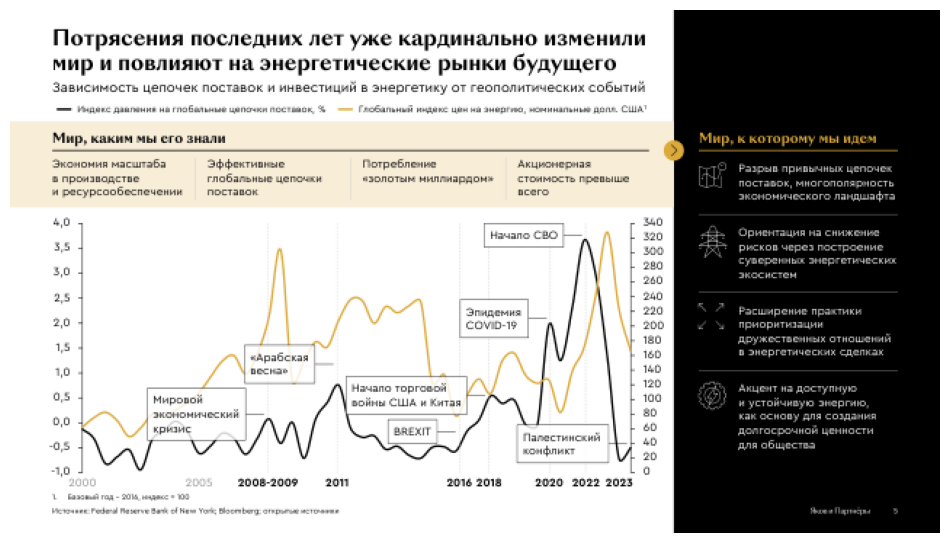

Слайд посвящен изменениям в энергетических рынках и их зависимости от геополитических 
событий. 

### Заголовок:
"Потрясения последних лет уже кардинально изменили мир и повлияют на энергетические рынки 
будущего"

### Подзаголовок:
"Зависимость цепочек поставок и инвестиций в энергетику от геополитических событий"

### График:
- **Ось Y (слева):** Индекс цен на энергоносители (в условных единицах от 0 до 3,5)
- **Ось Y (справа):** Глобальный индекс цепи цен на энергию (в условных единицах от 0 до 
340)
- **Ось X:** Временной период с 2006 по 2023 год

#### Линии:
- **Черная линия:** Глобальный индекс цен на энергию
- **Оранжевая линия:** Индекс цепочек поставок

#### События на графике:
- 2008-2009: Мировой экономический кризис
- 2010-2011: Арабская весна
- 2016: BREXIT
- 2018: Начало торговой войны США и Китая
- 2020: Эпидемия COVID-19
- 2022: Начало СВО
- 2023: Падение банков США

### Текст справа:
"Мир, к которому мы идем"
- Гибрид управления цепочками поставок, многовекторность эк

In [152]:
image = page2image(pages[0], dpi=48)
out = query_and_display(image)

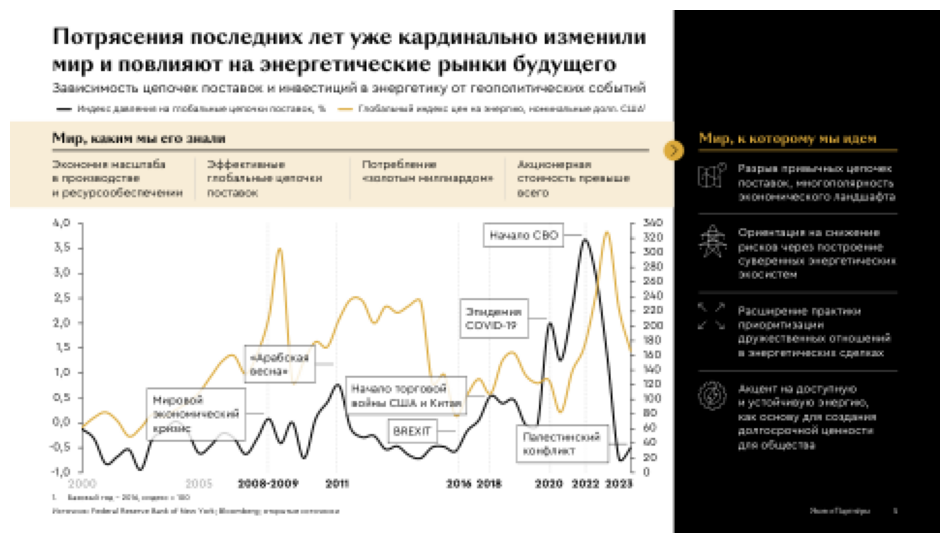

Слайд содержит информацию о влиянии глобальных событий на энергетические рынки. 

### Заголовок:
"Потрясения последних лет уже кардинально изменили мир и влияют на энергетические рынки 
будущего."

### Подзаголовок:
"Зависимость цепочек поставок и инвестиций в энергетику от геополитических событий."

### График:
- **Ось Y (слева):** Экономические показатели в процентах.
- **Ось Y (справа):** Индекс цен на энергоносители.
- **Ось X:** Временная шкала с 2005 по 2023 год.
- **Линии:**
  - Черная линия: Экономические показатели.
  - Оранжевая линия: Индекс цен на энергоносители.

### Важные события на графике:
- 2008-2009: Мировой экономический кризис.
- 2018: Начало торговой войны США и Китая.
- 2020: Пандемия COVID-19.
- 2022: Начало СВО (специальной военной операции).

### Боковая панель:
"Мир, к которому мы идем"
- Пункт 1: Резкие изменения цепочек поставок.
- Пункт 2: Ожидание роста инвестиций в устойчивую энергетику.
- Пункт 3: Рост цен на энергоносители.
- Пункт 4: Усиление роли воз

In [153]:
image = page2image(pages[0], dpi=36)
out = query_and_display(image)

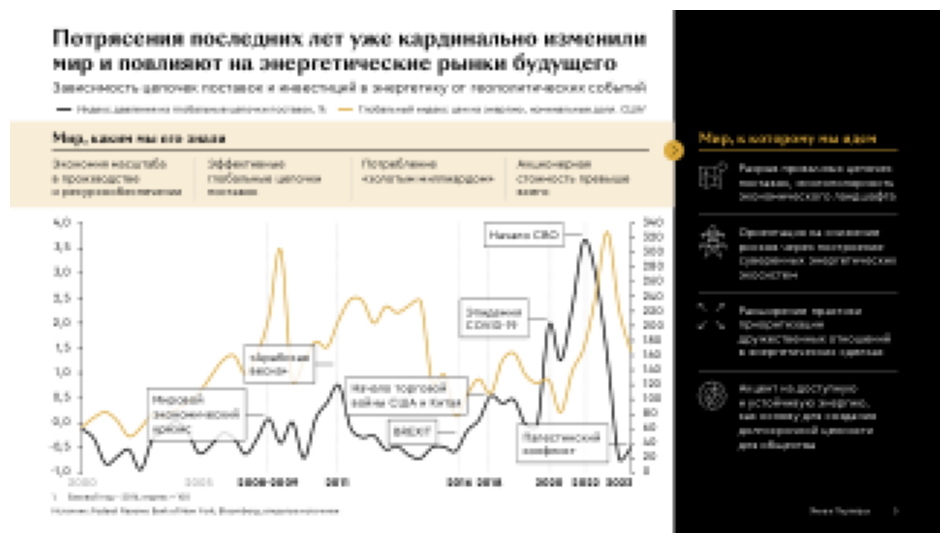

Слайд содержит график и текстовую информацию, разделённую на две основные части.

### Левая часть слайда:

**Заголовок:**
"Потрясения последних лет уже кардинально изменили мир и повлияют на энергетические рынки 
будущего"

**Подзаголовок:**
"Зависимость цепочек поставок и инвестиций в энергетику от геополитических событий"

**График:**
- Ось Y слева: Цена на нефть (в долларах США за баррель)
- Ось Y справа: Индекс цен на газ
- Ось X: Временной период с 2018 по 2023 год
- Две линии: 
  - Черная линия представляет индекс цен на газ.
  - Оранжевая линия представляет цену на нефть.
- На графике отмечены ключевые события:
  - "Пандемия COVID-19"
  - "Начало торговой войны США и Китая"
  - "Соглашение ОПЕК+"
  - "Начало СВО"
  - "Энергетический кризис в Европе"

### Правая часть слайда:

**Заголовок:**
"Мир в контексте надвигающихся изменений"

**Текст:**
- "Энергетический переход ускоряется"
- "Инвестиции в ВИЭ растут"
- "Геополитическая нестабильность"
- "Изменения в цепочках поставок"
- 

In [154]:
image = page2image(pages[0], dpi=24)
out = query_and_display(image)

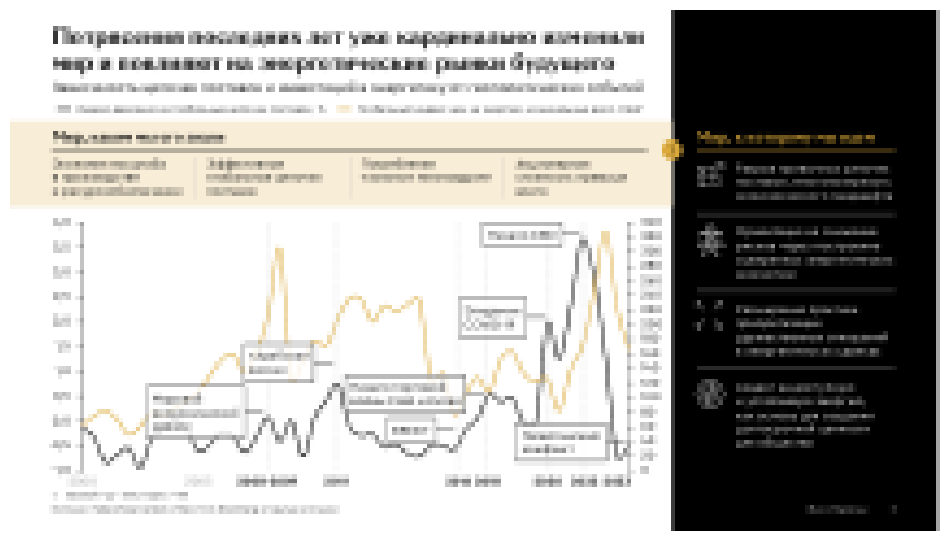

Слайд состоит из двух основных частей: графика и текстового блока.

### Левая часть (график):
- **Заголовок:** "Потрясения последних лет уже кардинально изменили мир и повлияют на 
энергетические рынки будущего".
- **Подзаголовок:** "Мировые цены на газ".
- **График:** Линии показывают изменения цен на газ с 2000 по 2022 год.
  - **Черная линия:** Цена на газ в США.
  - **Оранжевая линия:** Цена на газ в Европе.
- **Ключевые события на графике:**
  - 2008: Финансовый кризис.
  - 2011: Арабская весна.
  - 2014: Кризис на Украине.
  - 2020: Пандемия COVID-19.
  - 2022: Конфликт в Украине.

### Правая часть (текстовый блок):
- **Заголовок:** "Мир, в котором мы живем".
- **Список с иконками:**
  1. **Иконка глобуса:** Глобальные потрясения влияют на энергетические рынки.
  2. **Иконка графика:** Цены на энергоносители нестабильны.
  3. **Иконка завода:** Изменения в производстве и потреблении энергии.
  4. **Иконка руки с монетой:** Экономические последствия для стран и компаний.

Фон слай

In [155]:
image = page2image(pages[0], dpi=16)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

ГПТ не различает качество слайда. Просьба отреагировать на непонятный текст не сработала: 
- "Если на слайде есть текст, но ты не можешь его различить, напиши об этом. Не пытайся восстановить содержимое."

In [18]:
image = page2image(pages[0], dpi=16)
out = query_and_display(
    image, 
    display_image=False,
    vision_prompt=dedent(
        """\
        Представь, что я ничего не вижу. \
        Я пришлю тебе слайд из презентации, а ты опиши его. \
        Передай мне содержимое слайда в мельчайших подробностях.
                         
        Если на слайде есть текст, но ты не можешь его различить, напиши об этом. \
        Не пытайся восстановить содержимое.
        """
    )
)
print(text_wrapper.fill(out["llm_output"]))

На слайде представлена информация о влиянии климатических изменений на энергетические 
рынки. 

### Левая часть слайда:
- **Заголовок:** Говорит о последствиях климатических изменений за последние десятилетия.
- **График:** 
  - Две линии: одна черная, другая оранжевая.
  - Ось X: временная шкала с 2000 по 2022 год.
  - Ось Y: вероятно, отражает какой-то количественный показатель.
  - На графике отмечены несколько пиков и спадов, сопровождаемые текстовыми пояснениями.

- **Текстовые блоки над графиком:** 
  - Описывают различные периоды и события, влияющие на изменения на графике.

### Правая часть слайда:
- **Заголовок:** "Мир, в котором мы живем".
- **Список:** Несколько пунктов, каждый из которых сопровождается иконкой. Пункты 
описывают различные аспекты текущей ситуации в мире, связанные с климатом и энергетикой.

Цветовая гамма слайда включает черный, белый и оранжевый цвета.



---


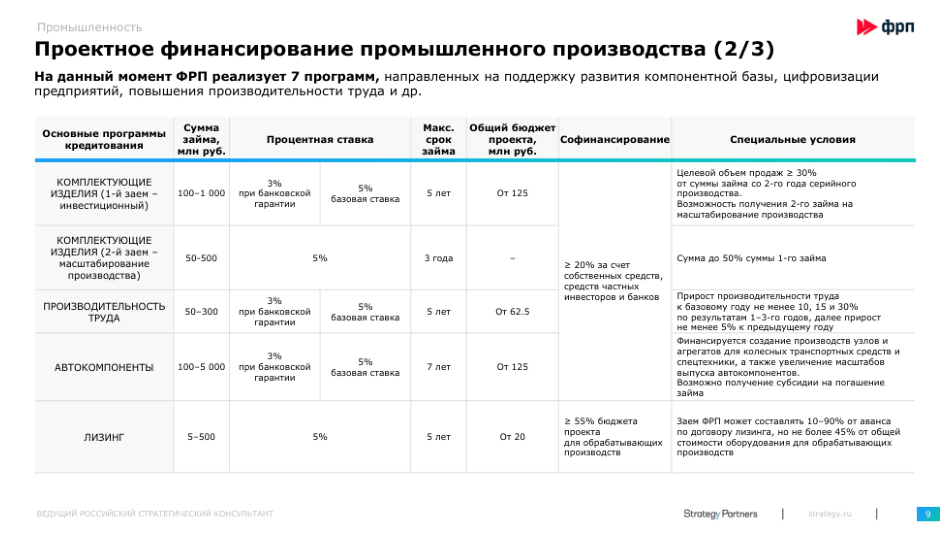

На слайде представлена информация о проектном финансировании промышленного производства. 
Это второй из трёх слайдов, посвящённых этой теме.

### Заголовок:
- **Промышленность**
- **Проектное финансирование промышленного производства (2/3)**

### Подзаголовок:
- На данный момент ФРП реализует 7 программ, направленных на поддержку развития 
компонентной базы, цифровизации предприятий, повышения производительности труда и др.

### Таблица с данными:
Таблица состоит из шести столбцов:

1. **Основные программы кредитования**
2. **Сумма займа, млн руб.**
3. **Процентная ставка**
4. **Макс. срок займа**
5. **Общий бюджет проекта, млн руб.**
6. **Софинансирование**
7. **Специальные условия**

#### Строки таблицы:

1. **Комплектующие изделия (1-й займ — инвестиционный)**
   - Сумма займа: 100–1 000 млн руб.
   - Процентная ставка: 3% при банковской гарантии, 5% базовая ставка
   - Макс. срок займа: 5 лет
   - Общий бюджет проекта: от 125 млн руб.
   - Специальные условия: Целевой объем продаж 

In [156]:
image = page2image(pages[1], dpi=72)
out = query_and_display(image)

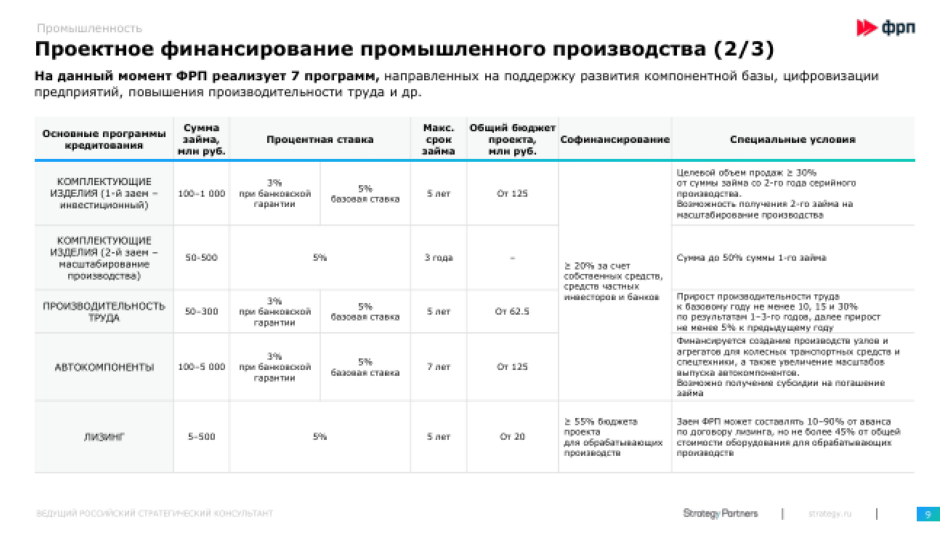

Слайд посвящен проектному финансированию промышленного производства. Он содержит таблицу с
 информацией о различных программах кредитования, реализуемых Фондом развития 
промышленности (ФРП). 

### Заголовок:
- **Проектное финансирование промышленного производства (2/3)**

### Подзаголовок:
- **На данный момент ФРП реализует 7 программ**, направленных на поддержку развития 
компонентной базы, цифровизации предприятий, повышения производительности труда и др.

### Таблица с колонками:
1. **Основные программы кредитования**
2. **Сумма займа, млн руб.**
3. **Процентная ставка**
4. **Макс. срок займа**
5. **Общий бюджет проекта, млн руб.**
6. **Софинансирование**
7. **Специальные условия**

### Строки таблицы:
1. **Комплектующие изделия (до 2-х замен импортозависимости)**
   - Сумма займа: 100-1 000 млн руб.
   - Процентная ставка: 1% при банковской гарантии, 5% базовая ставка
   - Макс. срок займа: 5 лет
   - Общий бюджет проекта: От 125 млн руб.
   - Софинансирование: —
   - Специальные 

In [157]:
image = page2image(pages[1], dpi=48)
out = query_and_display(image)

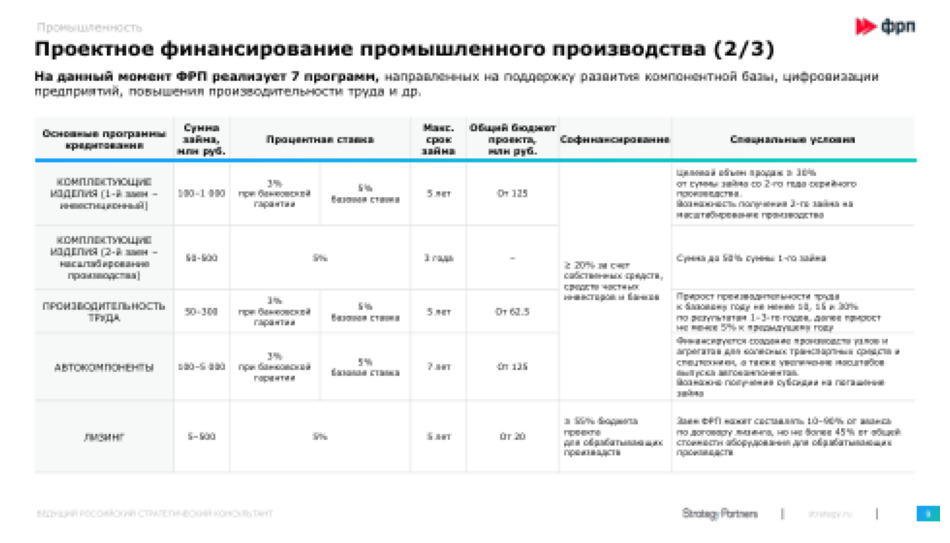

Слайд из презентации посвящен проектному финансированию промышленного производства. Он 
содержит таблицу с информацией о различных программах, реализуемых ФРП (Фондом развития 
промышленности).

### Заголовок:
- **Промышленность**
- **Проектное финансирование промышленного производства (2/3)**

### Подзаголовок:
- На данный момент ФРП реализует 7 программ, направленных на поддержку развития 
компонентной базы, цифровизации предприятий, повышения производительности труда и др.

### Таблица:
Таблица состоит из нескольких столбцов и строк, описывающих различные программы.

#### Столбцы:
1. **Основные параметры программы**
2. **Сумма займа, млн руб.**
3. **Процентная ставка**
4. **Макс. срок займа**
5. **Общий бюджет проекта, млн руб.**
6. **Софинансирование**
7. **Специальные условия**

#### Строки (Программы):
1. **Комплектующие изделия**
   - Сумма займа: 50-100 млн руб.
   - Процентная ставка: 1% - 3%
   - Макс. срок займа: 5 лет
   - Общий бюджет: от 125 млн руб.
   - Софинансирование

In [158]:
image = page2image(pages[1], dpi=36)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

Ошибки: 
- процентная ставка комплектующих изделий
- появилась строка "Цифровизация промышленности". В таблице ее нет.

Отсутствуют:
- софинансирование
- специальные условия

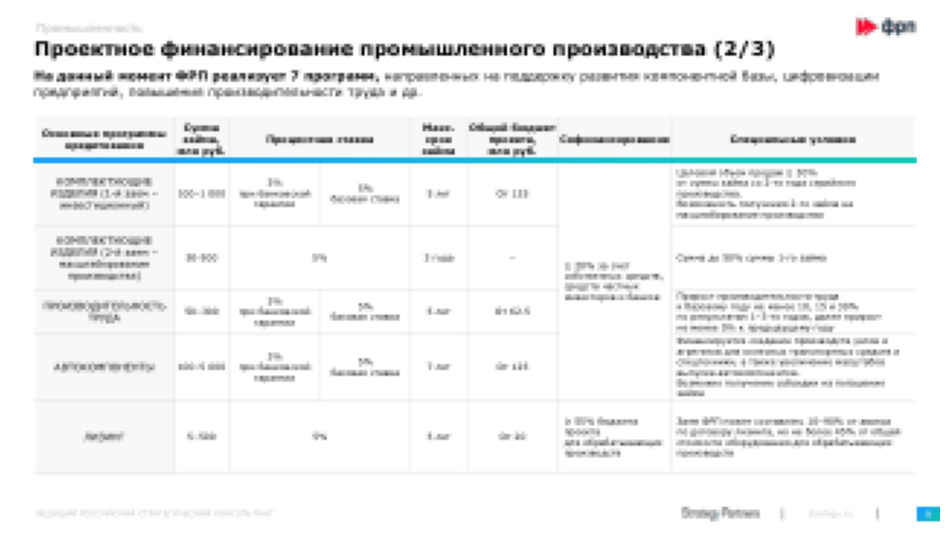

Слайд посвящен проектному финансированию промышленного производства. В верхней части 
слайда заголовок: "Проектное финансирование промышленного производства (2/3)". 
Подзаголовок сообщает, что Фонд развития промышленности (ФРП) реализует 7 программ, 
направленных на поддержку развития ключевых баз, цифровизации предприятий и повышения 
производительности труда.

Содержимое слайда представлено в виде таблицы с несколькими столбцами:

1. **Наименование программы кредитования**: 
   - Цифровизация промышленности
   - Производительность труда
   - Автокомпоненты
   - Лизинг

2. **Ставка для заемщика, годовых**: 
   - Указаны процентные ставки для каждой программы.

3. **Процентная ставка**: 
   - Приведены конкретные значения процентных ставок.

4. **Макс. срок кредита, лет**: 
   - Указаны максимальные сроки кредитования.

5. **Объем займа, млн руб.**: 
   - Приведены диапазоны возможных объемов займа.

6. **Софинансирование**: 
   - Указаны условия софинансирования.

7. **Специальные усл

In [159]:
image = page2image(pages[1], dpi=24)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

Полная галюцинация

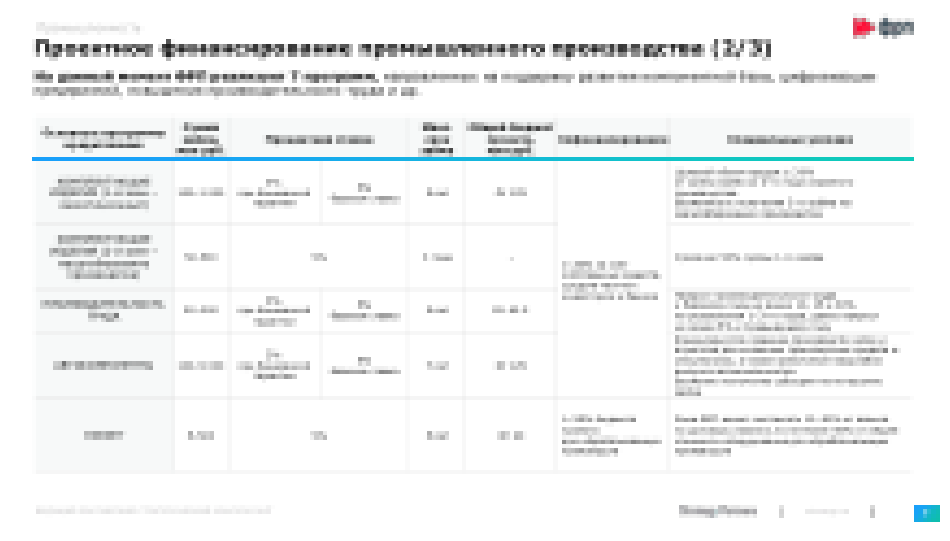

Слайд из презентации посвящён проектному финансированию промышленного производства. В 
верхней части слайда заголовок: "Проектное финансирование промышленного производства 
(2/3)". 

Слева в таблице перечислены различные программы и условия финансирования:

1. **Фонд развития промышленности (ФРП)**
   - Программы: "Проекты развития", "Комплектующие изделия", "Лизинг", "Конверсия".
   - Сумма займа: от 50 до 500 млн рублей.
   - Ставка: 1% или 3% годовых.
   - Срок: до 7 лет.
   - Собственное участие: от 30%.

2. **Региональные программы**
   - Условия варьируются в зависимости от региона.

Справа от таблицы указаны дополнительные условия и примечания:

- Условия предоставления финансирования.
- Требования к проектам.
- Возможные льготы и субсидии.

В правом верхнем углу логотип ФРП. Внизу слайда указаны источники информации и контактные 
данные.


In [160]:
image = page2image(pages[1], dpi=16)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

Он пытался ...


---


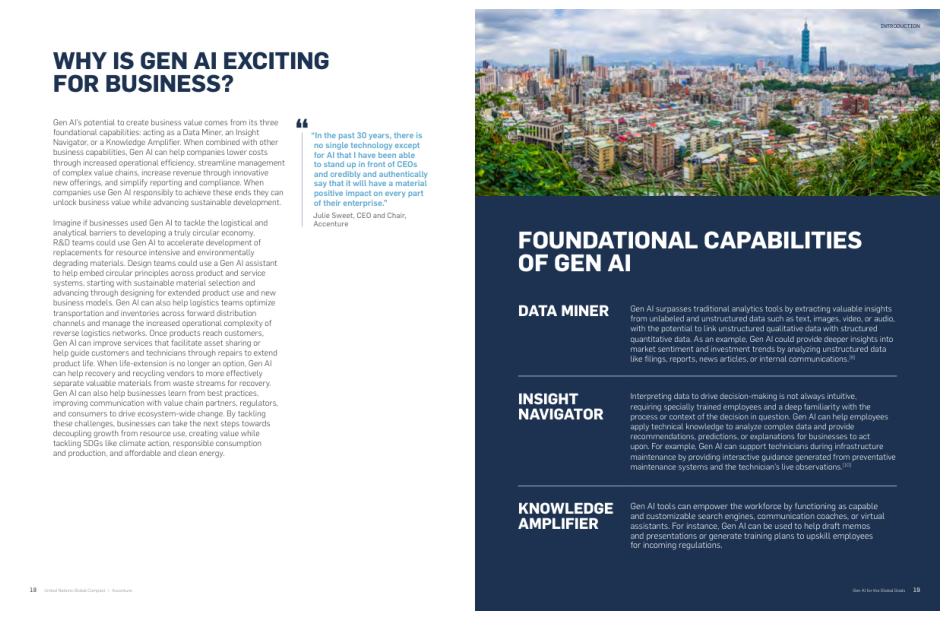

Слайд разделён на две основные части.

**Левая часть:**

- Заголовок: "WHY IS GEN AI EXCITING FOR BUSINESS?"
- Текст описывает потенциал генеративного ИИ (Gen AI) для создания бизнес-ценности. 
Упоминаются три основные возможности: Data Miner, Insight Navigator и Knowledge Amplifier.
- Приводятся примеры использования Gen AI в бизнесе, такие как оптимизация логистики, 
улучшение дизайна продуктов и поддержка устойчивого развития.
- Вставка с цитатой: 
  - Текст: "In the past 30 years, there is no single technology except for AI that I have 
been able to stand up in front of CEOs and credibly and authentically say that it will 
have a material positive impact on every part of their enterprise."
  - Автор: Julie Sweet, CEO and Chair, Accenture.

**Правая часть:**

- В верхней части изображение города с небоскрёбами и зеленью на переднем плане.
- Заголовок: "FOUNDATIONAL CAPABILITIES OF GEN AI"
- Описание трёх возможностей:
  - **DATA MINER**: Gen AI извлекает ценные инсайты из неструктур

In [161]:
image = page2image(pages[2], dpi=72)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

Нет мелкого текста рядом с номерами страницы

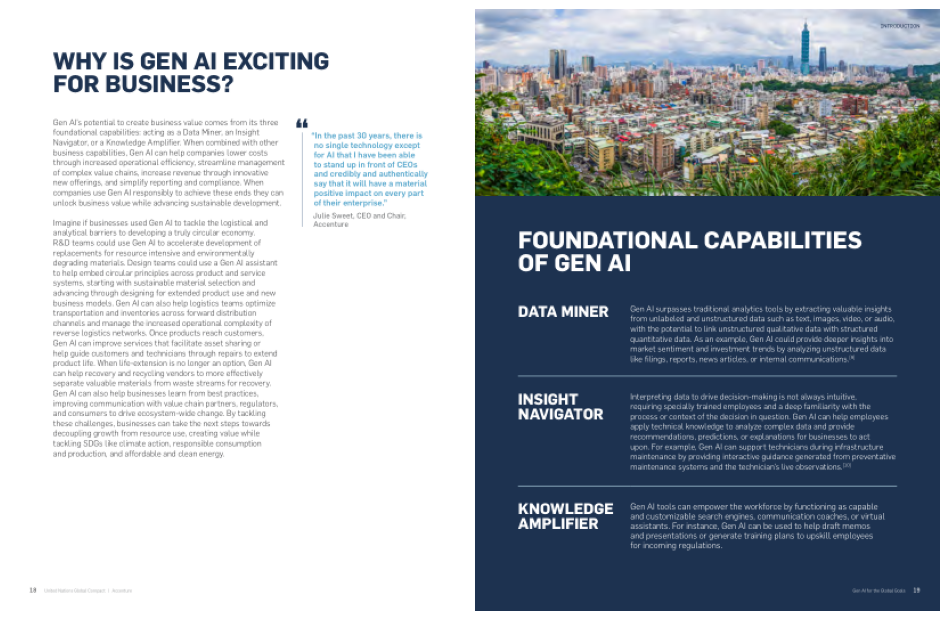

Слайд разделён на две основные части.

**Левая часть:**

- Заголовок: "WHY IS GEN AI EXCITING FOR BUSINESS?"
- Текст описывает потенциал генеративного ИИ для бизнеса, выделяя три основные 
возможности: Data Miner, Insight Navigator и Knowledge Amplifier. 
- Упоминается, что ИИ может помочь снизить затраты, улучшить операционную эффективность, 
упростить управление цепочками поставок и повысить доходы через инновации.
- Приводится пример использования ИИ для решения логистических и аналитических задач, 
разработки новых продуктов и улучшения обслуживания клиентов.
- Цитата от Джули Суит, CEO и председателя Accenture, о значимости технологий ИИ для 
бизнеса.

**Правая часть:**

- Заголовок: "FOUNDATIONAL CAPABILITIES OF GEN AI"
- Подзаголовки и описания:
  - **DATA MINER:** ИИ извлекает ценные инсайты из неструктурированных данных, таких как 
текст, изображения, видео и аудио, и может анализировать рыночные настроения и тренды.
  - **INSIGHT NAVIGATOR:** ИИ помогает в интерпретации данны

In [162]:
image = page2image(pages[2], dpi=48)
out = query_and_display(image)

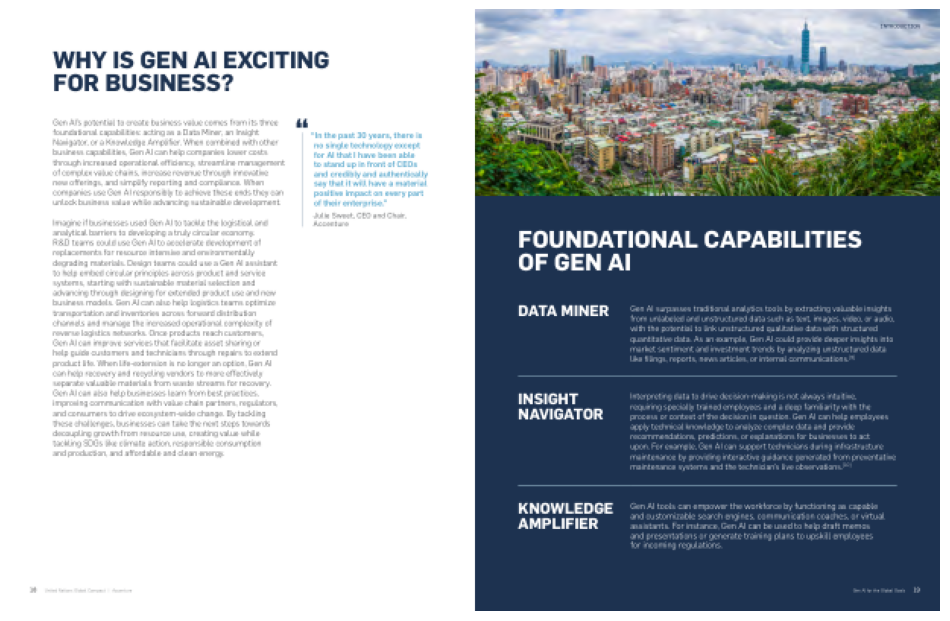

Слайд разделён на две части.

**Левая часть:**

- Заголовок: "WHY IS GEN AI EXCITING FOR BUSINESS?"
- Текст описывает, как генеративный ИИ может создавать бизнес-ценность через три ключевые 
возможности: генерация данных, навигация по инсайтам и усиление знаний. Упоминается, что 
ИИ может улучшать процессы, такие как управление цепочками поставок и обслуживание 
клиентов.
- Вставка с цитатой: "In the past 30 years, there is no technology that has been adopted 
as fast or broadly as Gen AI, and there is no technology that has been as enthusiastically
 embraced by end users." — Paul Daugherty, Chief Technology & Innovation Officer, 
Accenture.

**Правая часть:**

- Фоновое изображение города с небоскрёбами.
- Заголовок: "FOUNDATIONAL CAPABILITIES OF GEN AI"
- Подзаголовки и описания:
  - "DATA MINER": Генеративный ИИ улучшает традиционный анализ данных, предоставляя ценные
 инсайты.
  - "INSIGHT NAVIGATOR": Интеграция данных в принятие решений, улучшение стратегий.
  - "KNOWLEDGE AMPLIFI

In [163]:
image = page2image(pages[2], dpi=36)
out = query_and_display(image)

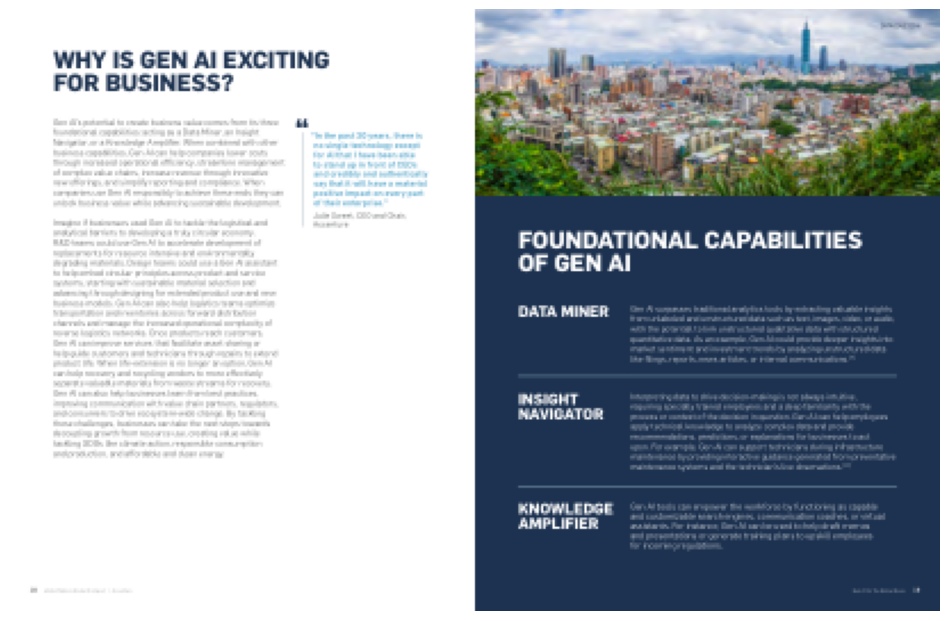

Слайд разделён на две части.

**Левая часть:**

- Заголовок: "WHY IS GEN AI EXCITING FOR BUSINESS?"
- Текст под заголовком объясняет, как генеративный искусственный интеллект (Gen AI) может 
трансформировать бизнес. Упоминается, что Gen AI способен создавать контент, 
автоматизировать процессы и улучшать взаимодействие с клиентами. Также говорится о его 
потенциале в различных отраслях, таких как маркетинг, финансы и здравоохранение.
- Вставка с текстом в голубом прямоугольнике: "In the past 20 years, there’s been a 14x 
increase in the number of AI startups, and a 6x increase in AI investments. Source: 
Stanford University, 2021."

**Правая часть:**

- Фотография города с высоты, на фоне видны небоскрёбы и зелёные насаждения.
- Заголовок: "FOUNDATIONAL CAPABILITIES OF GEN AI"
- Подзаголовки и описания:
  - "DATA MINER": Описывает, как Gen AI может анализировать большие объёмы данных для 
выявления скрытых закономерностей и предоставления ценной информации.
  - "INSIGHT NAVIGATOR": Гов

In [164]:
image = page2image(pages[2], dpi=24)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

Ошибки:
- "In the last 20 years" - в тексте "30 years"


---


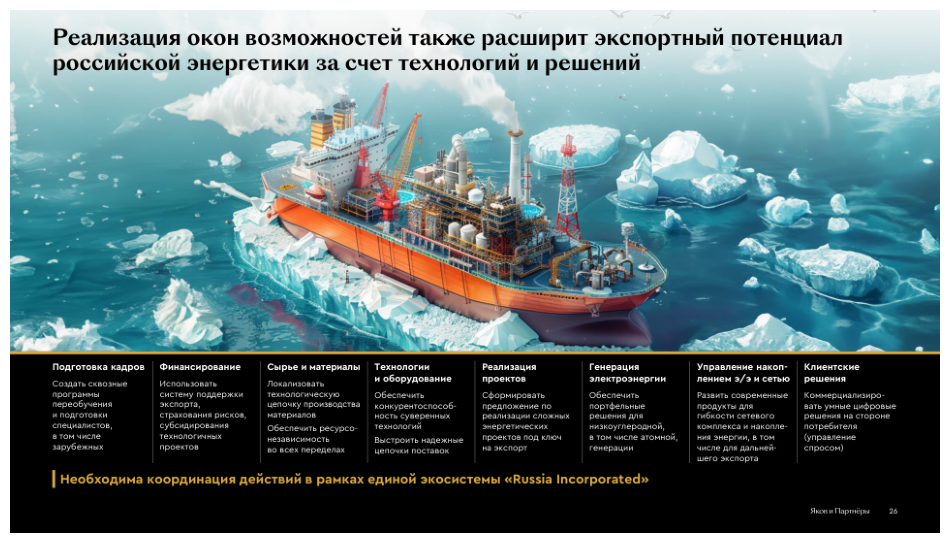

Слайд содержит изображение и текст. 

**Изображение:**
На фоне арктического пейзажа с айсбергами изображено крупное судно, напоминающее нефтяную 
платформу или танкер. Оно окружено льдами и плавает в холодных водах.

**Текст:**
В верхней части слайда крупным шрифтом написано: 
"Реализация окон возможностей также расширит экспортный потенциал российской энергетики за
 счет технологий и решений".

В нижней части слайда на черном фоне расположены блоки с текстом:

1. **Подготовка кадров:**
   - Создать сквозные программы переобучения и подготовки специалистов, в том числе за 
рубежом.

2. **Финансирование:**
   - Использовать систему поддержки экспорта, страхования рисков, субсидирования 
технологичных проектов.

3. **Сырье и материалы:**
   - Локализовать технологическую цепочку производства материалов.
   - Обеспечить ресурсонезависимость во всех переделах.

4. **Технологии и оборудование:**
   - Обеспечить конкурентоспособность суверенных технологий.
   - Вернуться на технологическое л

In [165]:
image = page2image(pages[3], dpi=72)
out = query_and_display(image)

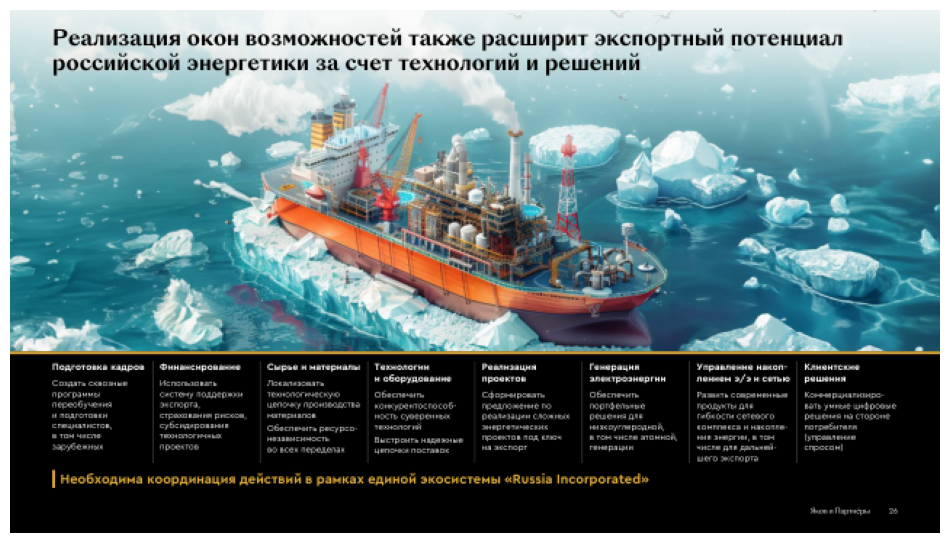

На слайде изображен большой корабль, похожий на нефтяную платформу, окруженный айсбергами 
в арктических водах. На заднем плане видны заснеженные горы и ледяные поля. 

В верхней части слайда написан заголовок: "Реализация окон возможностей также расширит 
экспортный потенциал российской энергетики за счет технологий и решений".

Ниже изображение корабля разделено на несколько секций с текстом:

1. **Подготовка кадров**: 
   - Связь системы образования с потребностями отрасли.
   - Привлечение специалистов из-за рубежа.

2. **Финансирование**:
   - Инвестиции в долгосрочные инфраструктурные проекты.

3. **Сырье и материалы**:
   - Использование отечественного сырья и материалов.
   - Развитие новых технологий добычи.

4. **Технологии и оборудование**:
   - Обеспечение технологической независимости.
   - Локализация производства.

5. **Реализация продукции**:
   - Расширение географии поставок.
   - Увеличение доли экспорта.

6. **Генерация энергии**:
   - Обеспечение внутреннего рынка.

In [166]:
image = page2image(pages[3], dpi=48)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

Галлюцинация "Якорь в Перспективу" около номера страницы

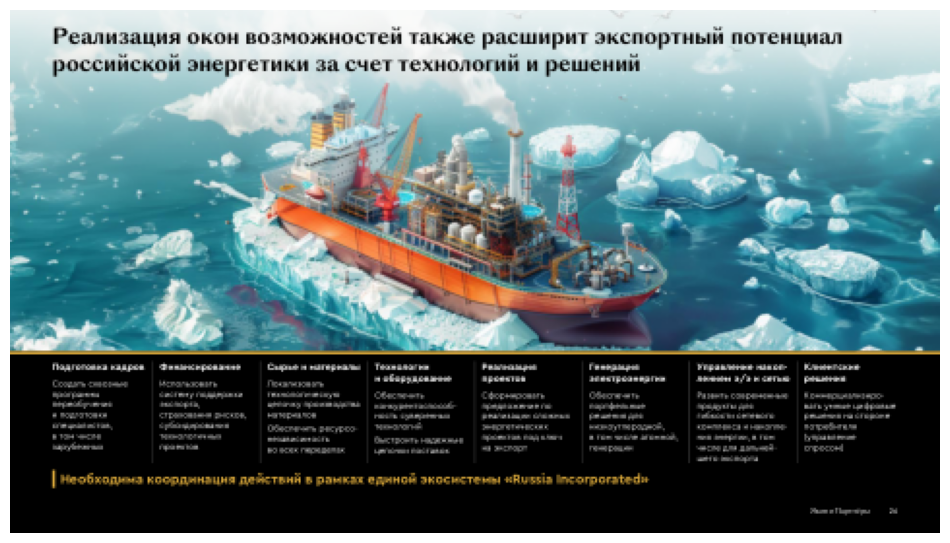

Слайд содержит изображение и текст. 

**Изображение:**
На фоне арктического пейзажа с айсбергами изображена крупная платформа или судно, 
связанное с добычей или транспортировкой нефти или газа. На судне видны различные 
конструкции, такие как краны и оборудование.

**Текст:**
В верхней части слайда крупным шрифтом написано: 
"Реализация окон возможностей также расширит экспортный потенциал российской энергетики за
 счет технологий и решений."

Ниже изображены иконки и текстовые блоки, которые описывают различные аспекты или этапы 
процесса:

1. **Подготовка кадров** - Создание системы подготовки кадров для новых отраслей.
2. **Финансирование** - Привлечение инвестиций и создание финансовых инструментов.
3. **Сырье и материалы** - Обеспечение доступа к сырью и материалам.
4. **Технологическое обеспечение** - Разработка и внедрение новых технологий.
5. **Производственные мощности** - Создание и модернизация производственных мощностей.
6. **Гуманитарное обеспечение** - Обеспечение социал

In [167]:
image = page2image(pages[3], dpi=36)
out = query_and_display(image)

$\color{green}{\textsf{Комментарий:}}$

Ошибки во всех текстовых блоках

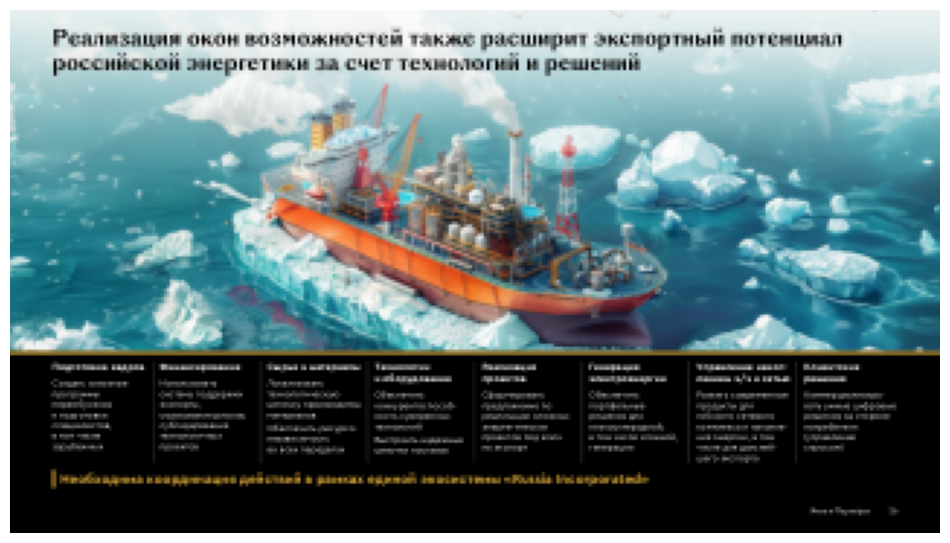

На слайде изображен корабль, плывущий среди льдов в арктических водах. На корабле видны 
различные установки и оборудование, характерные для добычи и транспортировки 
энергоресурсов. 

В верхней части слайда размещен текст: "Реализация окон возможностей также расширит 
экспортный потенциал российской энергетики за счет технологий и решений".

Ниже изображения корабля находится черная полоса с текстом, разделенным на несколько 
колонок. В каждой колонке перечислены различные аспекты или направления, связанные с 
энергетикой:

1. **Перспективы и вызовы**: 
   - Углубление международного сотрудничества
   - Развитие новых технологий

2. **Технологические решения**: 
   - Инновации в добыче
   - Эффективность транспортировки

3. **Экологические аспекты**: 
   - Снижение выбросов
   - Защита окружающей среды

4. **Экономические выгоды**: 
   - Увеличение экспорта
   - Рост инвестиций

5. **Геополитические факторы**: 
   - Усиление позиций на мировом рынке
   - Новые партнерства

6. **Социал

In [168]:
image = page2image(pages[3], dpi=24)
out = query_and_display(image)